#### Logo BG 0418 variations

First

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as image
from numpy.random import random_integers as rand
import numpy as np

In [2]:
'''
Image saver. Put any matrix in, and it will be saved as a PNG image.
It looks exactly the same as if it's plotted.
Do not put a default filename in!
'''
def savePattern(filename_, imgmatrix_, dpi_=100, cmap_=plt.cm.inferno):
    im = image
    image.imsave(fname=filename_, arr=imgmatrix_, dpi=dpi_, cmap=cmap_)
    



In [198]:
class Blend:
    
    def __init__(self):
        self.background = 0
        self.pattern = 0
        self.pattern_alpha = 0

    def blend(self, inputName, patternName, outputName):
        self.background = image.imread(inputName)
        self.pattern = image.imread(patternName)
        self.pattern_alpha = np.empty([len(pattern), len(pattern[0]), 4])
        
        for i in range(0, len(self.pattern)):
            for j in range(0, len(self.pattern[i])):
                pixel = self.pattern[i][j]
                self.pattern_alpha[i][j] = [1, 1, 1, 1 - pixel[0]]
        
        self.centerX = len(self.background)//2 - len(self.pattern_alpha)//2
        self.centerX = len(self.background[0])//2 - len(self.pattern_alpha[0])//2
        
        self.endX = self.centerX + len(pattern_alpha)
        self.endY = self.centerY + len(pattern_alpha)
        
        result = np.empty([len(self.background), len(self.background[0]), 3])

        for i in range(0, len(self.background)):
            for j in range(0, len(self.background[0])):
                if self.centerX <= i < self.endX and self.centerY <= j < self.endY:
                    aX = i - self.centerX
                    aY = j - self.centerY
                    aPixel = self.pattern_alpha[aX][aY]
                    if aPixel[3] > 0:
                        result[i][j] = [1, 1, 1]
                    else:
                        pixel = self.background[i][j]
                        result[i][j] = [pixel[0], pixel[1], pixel[2]]
                else:
                    pixel = self.background[i][j]
                    result[i][j] = [pixel[0], pixel[1], pixel[2]]

        image.imsave(outputName, result)
        
class Blend2:
    
    #def __init__(self):
        
    
    def blend(self, inputMatrix, backgroundFileName, outputFileName):
        background = image.imread(backgroundFileName)
        #image.imsave(fname=filename_, arr=imgmatrix_, dpi=dpi_, cmap=cmap_)
        image.imsave(\
                     fname=outputFileName,\
                     arr=self.merge_matrices(\
                                             inputMatrix,\
                                             background,\
                                             x=150,\
                                             y=background.shape[1]//2-inputMatrix.shape[1]//2
                                            ))
        
        
    def merge_matrices(self, inputMatrix, backgroundMatrix, x=0, y=0):
        print(x)
        sx = inputMatrix.shape[0]
        sy = inputMatrix.shape[1]
        for ix in range(0,sx):
            for iy in range(0,sy):
                if inputMatrix[ix,iy]==1000:
                    #1a1a1a if 1000
                    backgroundMatrix[ix+x,iy+y] = [26/256,26/256,26/256,1]
                if inputMatrix[ix,iy]==2000:
                    #ffffff if 2000
                    backgroundMatrix[ix+x,iy+y] = [1.,1.,1.,1.] #ffffff
        return backgroundMatrix

In [190]:
'''
Element is just a position handling class.
    - setPosition() sets the position directly
    - move() adds the given matrix or coordinates
'''
class Element(object):
    position=np.matrix([0,0])
    def __init__(self, x_=0, y_=0):
        self.position=np.matrix([x_,y_])
        self.setPosition(x_, y_)
        
    def __del__(self):
        del self
        
    def setPosition(self, x_=0, y_=0):
        self.position=np.matrix([x_,y_])
        
    def move(self, x_, y_):
        self.position+=np.matrix([x_, y_])
        
    def move(self, operand):
        self.position+=operand

In [191]:
class Node(Element):
    #position is for the node's position in the final image
    position = np.matrix([0,0])
    #token is a set of available branches that a node can put (obvi: in our case it can't be more than 3)
    token=2
    #freePoints are for listing the checked positions where the node can put another node (branch)
    freePoints=[]
    #you can specify a bias that can modify the shape of the tree
    #bias[up,right,down,left]
    bias=[]
    
    def __init__(self, position_=0, bias_=[100,2,1,2]):
        self.position = position_
        self.bias=bias_
        self.token=2
        
    '''
    Check if got any places around in orthogonal edges of nodeArea.
    nodeArea is a StartingNest.nodeArea * StartingNest.nodeArea shaped matrix around the node.
    '''
    def checkNeighbour(self, nodeArea=0):
        #get the center point
        centerX = nodeArea.shape[0]//2
        centerY = nodeArea.shape[1]//2
        #check the free points
        #collect them into self.freePoints array
        #flushing the freePoints list
        self.freePoints=[]
        #checking the upper section
        #print("------------------------")
        #print("area:")
        #print(nodeArea)
        
        #checking the top section
        if np.count_nonzero(nodeArea[0:centerX, centerY])==0:
            #print("up ok")
            freePoint = [0, centerY]
            self.freePoints.append('u')
        #print("found branch values on up: ", np.count_nonzero(nodeArea[0:centerX, centerY]))
        
        #checking the right section
        if np.count_nonzero(nodeArea[centerX, (centerY+1):nodeArea.shape[1]])==0:
            #print("right ok")
            freePoint = [centerX, nodeArea.shape[1]]
            self.freePoints.append('r')
        #print("found branch values on right: ", np.count_nonzero(nodeArea[centerX, (centerY+1):nodeArea.shape[1]]))
        
        #checking the bottom section
        if np.count_nonzero(nodeArea[(centerX+1):nodeArea.shape[0], centerY])==0:
            #print("bottom ok")
            freePoint = [nodeArea.shape[0], centerY]
            self.freePoints.append('d')
        #print("found branch values on bottom: ", np.count_nonzero(nodeArea[(centerX+1):nodeArea.shape[0], centerY]))
        
        #checking the LEFT WING <plays proud russian hardtechno>
        if np.count_nonzero(nodeArea[centerX, 0:centerY])==0:
            #print("left ok")
            freePoint = [centerX, 0]
            self.freePoints.append('l')
        #print("found branch values on left: ", np.count_nonzero(nodeArea[centerX, 0:centerY]))
        return len(self.freePoints)
        
    def putNode(self, nodeArea, nest):
        #choose a freePoint from self.freePoints
        
        #newNodePosition=self.doArbitratedBranch(nodeArea, nest)
        newNodePosition=self.doArbitratedBranch(nodeArea, nest)

        #put a node and draw the line
        #print("actual position:", self.position)
        #print("chosen position:", newNodePosition)
        self.drawBranch(newNodePosition, nest)
        nest.addNode(newNodePosition)
        return 0
    
    def doArbitratedBranch(self, nodeArea, nest):
        newNodePosition=[]
        match=0
        while match==0:
            direction = self.getFreePointByBias()
            if direction == 0 and np.count_nonzero(np.isin(self.freePoints, 'u')):
                newNodePosition=[self.position[0,0]-(nodeArea.shape[0]//2),self.position[0,1]]
                match=1

            if direction == 1 and np.count_nonzero(np.isin(self.freePoints, 'r')):
                newNodePosition=[self.position[0,0],self.position[0,1]+(nodeArea.shape[1]//2)]
                match=1

            if direction == 2 and np.count_nonzero(np.isin(self.freePoints, 'd')):
                newNodePosition=[self.position[0,0]+(nodeArea.shape[0]//2),self.position[0,1]]
                match=1

            if direction == 3 and np.count_nonzero(np.isin(self.freePoints, 'l')):
                newNodePosition=[self.position[0,0],self.position[0,1]-(nodeArea.shape[1]//2)]
                match=1
        return newNodePosition
    
    def doUnArbitratedBranch(self, nodeArea, nest):
        newNodePosition=[]
        direction = self.getFreePointByBias()
        if direction == 0 and np.count_nonzero(np.isin(self.freePoints, 'u')):
            newNodePosition=[self.position[0,0]-(nodeArea.shape[0]//2),self.position[0,1]]

        if direction == 1 and np.count_nonzero(np.isin(self.freePoints, 'r')):
            newNodePosition=[self.position[0,0],self.position[0,1]+(nodeArea.shape[1]//2)]

        if direction == 2 and np.count_nonzero(np.isin(self.freePoints, 'd')):
            newNodePosition=[self.position[0,0]+(nodeArea.shape[0]//2),self.position[0,1]]

        if direction == 3 and np.count_nonzero(np.isin(self.freePoints, 'l')):
            newNodePosition=[self.position[0,0],self.position[0,1]-(nodeArea.shape[1]//2)]
        return newNodePosition
    
    def drawBranch(self, newPosition, nest):
        if len(newPosition)>0:
            if newPosition[0]>self.position[0,0]:
                lowerX=self.position[0,0]
                higherX=newPosition[0]
            else:
                lowerX=newPosition[0]
                higherX=self.position[0,0]
            if newPosition[0]==self.position[0,0]:
                lowerX=newPosition[0]
                higherX=self.position[0,0]+1

            if newPosition[1]>self.position[0,1]:
                lowerY=self.position[0,1]
                higherY=newPosition[1]
            else:
                lowerY=newPosition[1]
                higherY=self.position[0,1]
            if newPosition[1]==self.position[0,1]:
                lowerY=newPosition[1]
                higherY=self.position[0,1]+1

            if newPosition[0]<nest.area.shape[0] and newPosition[1]<nest.area.shape[1]:
                nest.area[newPosition[0], newPosition[1]] = 1000# nest.iterations+100
                nest.area[lowerX:higherX, lowerY:higherY] = 1000# nest.iterations+100
        
        return 0
    
    def getFreePointByBias(self):
        direction=[]
        #to up
        direction.append(np.random.rand(1)*self.bias[0])
        #to right
        direction.append(np.random.rand(1)*self.bias[1])
        #to down
        direction.append(np.random.rand(1)*self.bias[2])
        #to the dreamland
        direction.append(np.random.rand(1)*self.bias[3])
        return np.argmax(direction)
        
    def step(self, nodeArea, nest):
        if self.position[0,0]>nest.nodeArea and self.position[0,0]<nest.area.shape[0]-nest.nodeArea\
            and self.position[0,1]>nest.nodeArea and self.position[0,1]<nest.area.shape[1]-nest.nodeArea :
            freePoints = self.checkNeighbour(nodeArea)
            if self.token>0 and freePoints>0:
                self.token-=1
                self.putNode(nodeArea, nest)
        else:
            nest.area[self.position[0,0],self.position[0,1]]=2000
            self.token=0
            

In [192]:
'''
StartingNest is a class for start several StartingNode-s.
    - startingPositionMatrix : where the first nodes are
    - nodeArea : checked area on any node steps. it puts a new node on the edge of it.
                 it has to be an odd number!
    - 
'''

class StartingNest(Element, object):
    startingPositionMatrix=np.matrix([[0,1,0],[1,0,1],[0,1,0]])
    nodeArea=5
    nodes=[]
    iterations=10
    initial_iteration=0
    area=np.zeros([1,1])
    T0 = 0
    Td = 1
    
    def __init__(self, startingPositionMatrix_, nodeArea_=5, areaX_=100, areaY_=100, iterations=10, T0=1, Td=1):
        self.T0 = T0
        self.Td = Td
        self.startingPositionMatrix=startingPositionMatrix_
        self.nodeArea=nodeArea_
        nodes=[]
        self.area=np.zeros([areaX_, areaY_])
        self.iterations=iterations
        self.initial_iterations=iterations
        print("Created.")
        
    def __del__(self):
        print("Deleted.")        
    
    def setInitialNodes(self):
        self.nodes=[]
        centerX = self.area.shape[0]//2 - self.startingPositionMatrix.shape[0]//2
        centerY = self.area.shape[1]//2 - self.startingPositionMatrix.shape[1]//2
        self.area=self.mergeMatrices(imageMatrix=self.area, drawMatrix=self.startingPositionMatrix, x=centerX, y=centerY)
        plt.imshow(self.area, cmap=plt.cm.binary, interpolation='nearest')
        plt.show()
        
    def addNode(self, position, token=2):
        if len(position)>0:
            nodeToAdd=Node(np.matrix([position[0], position[1]]))
            #token = calculate_token_probability()>1 ? random.randint(2,4) : 1 
            #print(self.calculate_token_probability())
            if self.calculate_token_probability()>1:
                token = 2
            elif self.calculate_token_probability()>10:
                token = 3
            else:
                token = 1
            nodeToAdd.token=token
            self.nodes.append(nodeToAdd)
        
    '''
    Merge matrices. You can give an offset.
    returns: modified imageMatrix, nodePositions
    '''    
    def mergeMatrices(self, imageMatrix=0, drawMatrix=0, x=0, y=0):
        sx = drawMatrix.shape[0]
        sy = drawMatrix.shape[1]
        #nodePositions=[]
        for ix in range(0,sx):
            for iy in range(0,sy):
                imageMatrix[ix+x,iy+y] = drawMatrix[ix,iy]
                if imageMatrix[ix+x,iy+y] > 0:
                    self.addNode(position=[ix+x, iy+y], token=1)
                    #nodeToAdd=Node(np.matrix([ix+x, iy+y]))
                    #self.nodes.append(nodeToAdd)
        return imageMatrix
    
    def getArea(self, x_=0, y_=0):
        area = np.zeros([self.nodeArea, self.nodeArea])
        xPos=x_-self.nodeArea//2
        yPos=y_-self.nodeArea//2
        area = self.area[xPos:xPos+self.nodeArea, yPos:yPos+self.nodeArea]
        #plt.imshow(area, cmap=plt.cm.binary, interpolation='nearest')
        #plt.show()
        return area
    
    def saveForGif(self, filename, img, dpi=120, cmap=plt.cm.binary, scaling_=1):
        scaling = scaling_
        Z=np.kron(img, np.ones((scaling, scaling)))
        savePattern(filename_=filename, imgmatrix_=Z, dpi_=dpi, cmap_=cmap)
        
    def calculate_token_probability(self):
        x = self.initial_iterations - self.iterations
        if x > 0:
            Tp = (x**2)/((x**self.T0)*self.Td)
        else:
            Tp = 0
        return Tp
    
    def highlight_endpoints(self):
        for i in range(len(self.nodes)):
            if self.nodes[i].token == 2:
                self.area[self.nodes[i].position[0,0],self.nodes[i].position[0,1]] = 2000
    
    def run(self, branching_probability=.5):
        self.setInitialNodes()
        image_index=0
        
        while self.iterations>0:
            for i in range(0,len(self.nodes)):
                nodeArea=self.getArea(self.nodes[i].position[0,0], self.nodes[i].position[0,1])
                if np.random.rand(1) > branching_probability:
                    self.nodes[i].step(nodeArea, self)
            self.iterations-=1
            self.saveForGif(filename="test_viridis_gif_"+str("%03d" % image_index)+".png", img=self.area, dpi=300, cmap=plt.cm.inferno, scaling_=8)
            image_index+=1
        self.highlight_endpoints()
        

Created.
Deleted.


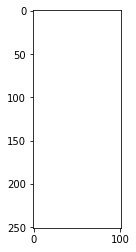

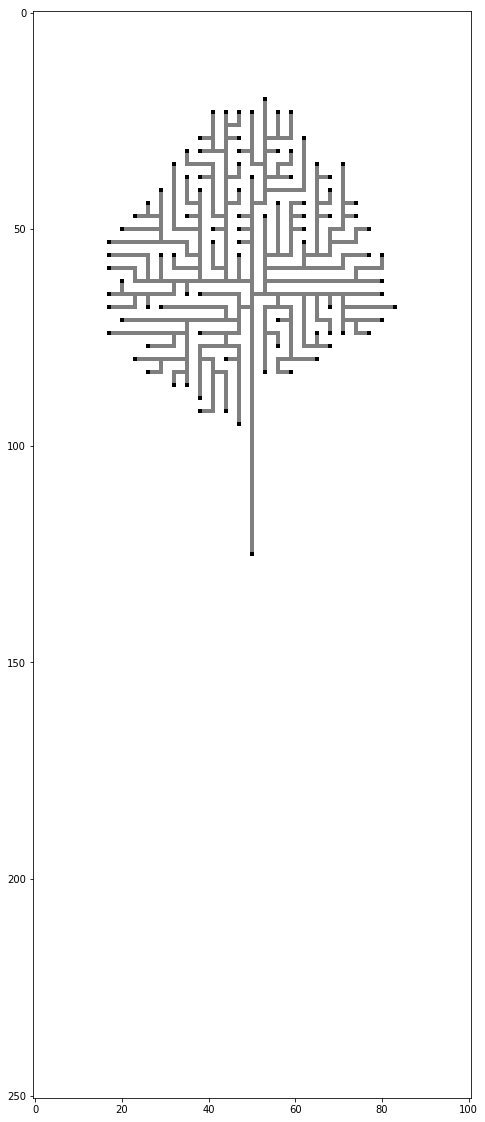

In [175]:
testNest = StartingNest(startingPositionMatrix_=np.matrix([[0,0,0,0,0,0,0,0,0,2000,0,0,0,0,0,0,0,0,0]]), nodeArea_=7, iterations=67, areaX_=251, areaY_=101, T0=.6, Td=150)
testNest.move(np.array([100,0]))
testNest.run(.5)
plt.figure(figsize = (20,20))
plt.imshow(testNest.area, cmap=plt.cm.binary, interpolation='nearest', aspect='equal')
plt.show()

Created.


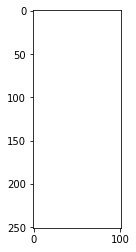

150
Ready: 000
Created.
Deleted.


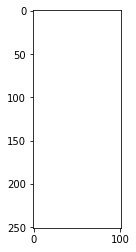

150
Ready: 001
Created.
Deleted.


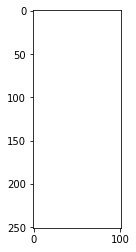

Deleted.
150
Ready: 002
Created.
Deleted.


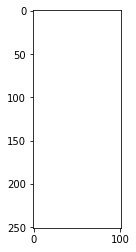

150
Ready: 003
Created.
Deleted.


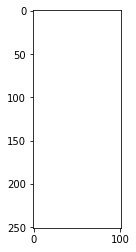

150
Ready: 004
Created.
Deleted.


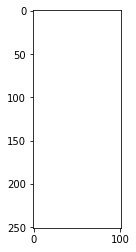

150
Ready: 005
Created.
Deleted.


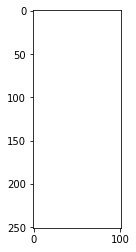

150
Ready: 006
Created.
Deleted.


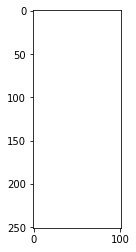

150
Ready: 007
Created.
Deleted.


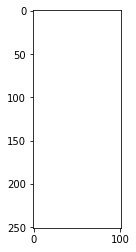

150
Ready: 008
Created.
Deleted.


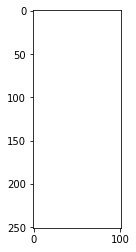

150
Ready: 009
Created.
Deleted.


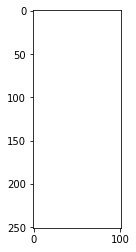

150
Ready: 010
Created.
Deleted.


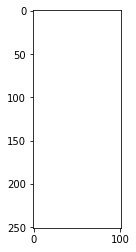

150
Ready: 011
Created.
Deleted.


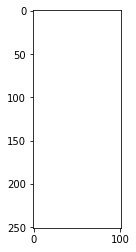

150
Ready: 012
Created.
Deleted.


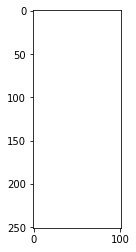

150
Ready: 013
Created.
Deleted.


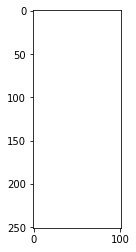

150
Ready: 014
Created.
Deleted.


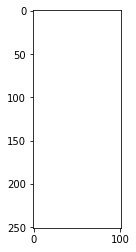

150
Ready: 015
Created.
Deleted.


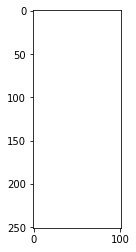

150
Ready: 016
Created.
Deleted.


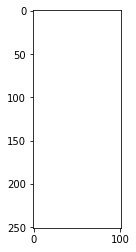

150
Ready: 017
Created.
Deleted.


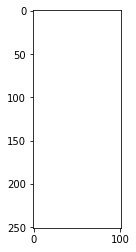

150
Ready: 018
Created.
Deleted.


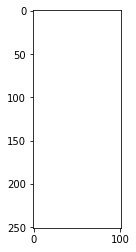

150
Ready: 019
Created.
Deleted.


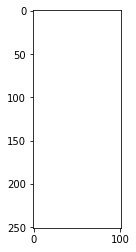

150
Ready: 020
Created.
Deleted.


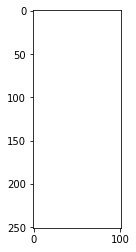

150
Ready: 021
Created.
Deleted.


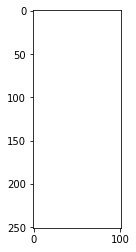

150
Ready: 022
Created.
Deleted.


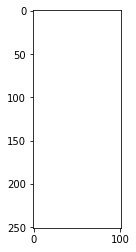

150
Ready: 023
Created.
Deleted.


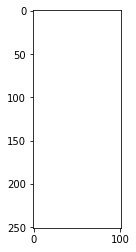

150
Ready: 024
Created.
Deleted.


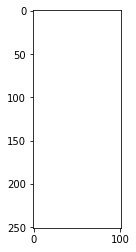

150
Ready: 025
Created.
Deleted.


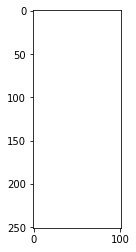

150
Ready: 026
Created.
Deleted.


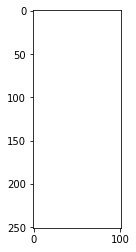

150
Ready: 027
Created.
Deleted.


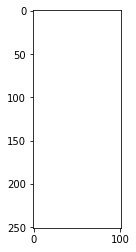

150
Ready: 028
Created.
Deleted.


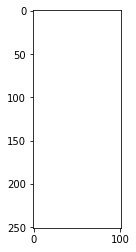

150
Ready: 029
Created.
Deleted.


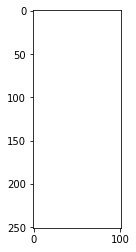

150
Ready: 030
Created.
Deleted.


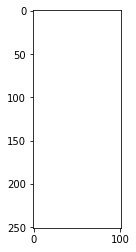

150
Ready: 031
Created.
Deleted.


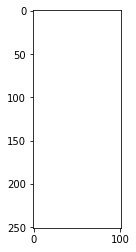

150
Ready: 032
Created.
Deleted.


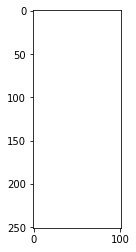

150
Ready: 033
Created.
Deleted.


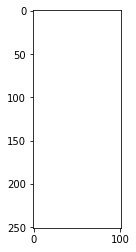

150
Ready: 034
Created.
Deleted.


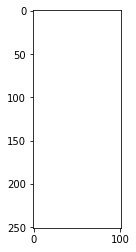

150
Ready: 035
Created.
Deleted.


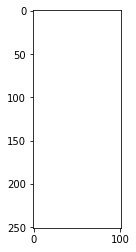

150
Ready: 036
Created.
Deleted.


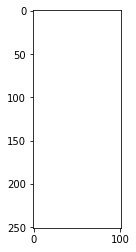

150
Ready: 037
Created.
Deleted.


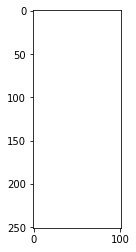

150
Ready: 038
Created.
Deleted.


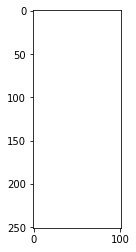

150
Ready: 039
Created.
Deleted.


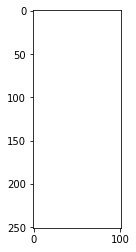

150
Ready: 040
Created.
Deleted.


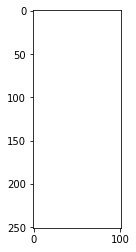

150
Ready: 041
Created.
Deleted.


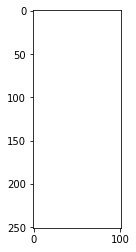

150
Ready: 042
Created.
Deleted.


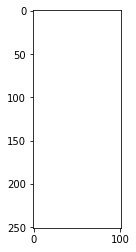

150
Ready: 043
Created.
Deleted.


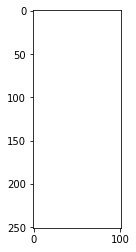

150
Ready: 044
Created.
Deleted.


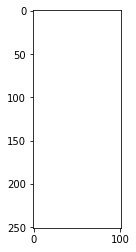

150
Ready: 045
Created.
Deleted.


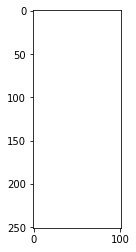

150
Ready: 046
Created.
Deleted.


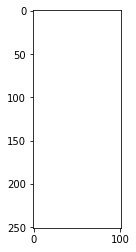

150
Ready: 047
Created.
Deleted.


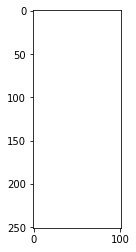

150
Ready: 048
Created.
Deleted.


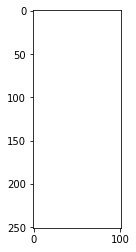

150
Ready: 049
Created.
Deleted.


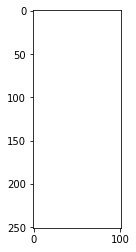

150
Ready: 050
Created.
Deleted.


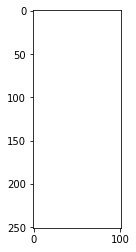

150
Ready: 051
Created.
Deleted.


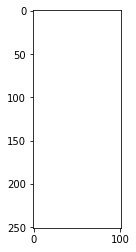

150
Ready: 052
Created.
Deleted.


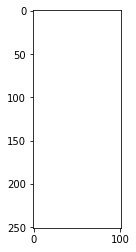

150
Ready: 053
Created.
Deleted.


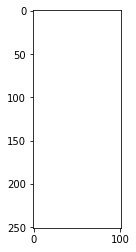

150
Ready: 054
Created.
Deleted.


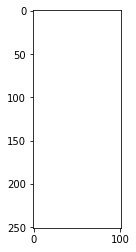

150
Ready: 055
Created.
Deleted.


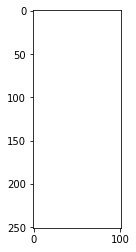

150
Ready: 056
Created.
Deleted.


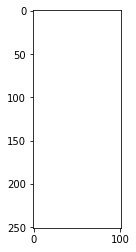

150
Ready: 057
Created.
Deleted.


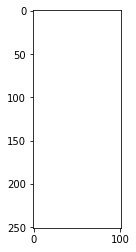

150
Ready: 058
Created.
Deleted.


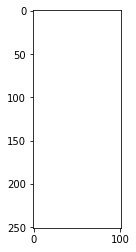

150
Ready: 059
Created.
Deleted.


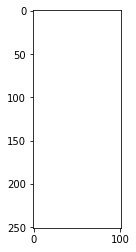

150
Ready: 060
Created.
Deleted.


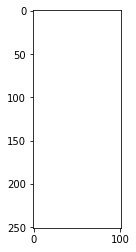

150
Ready: 061
Created.
Deleted.


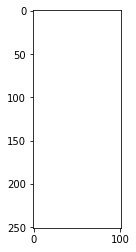

150
Ready: 062
Created.
Deleted.


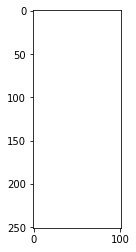

150
Ready: 063
Created.
Deleted.


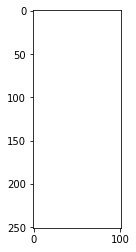

150
Ready: 064
Created.
Deleted.


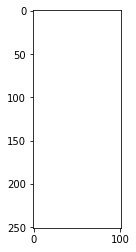

150
Ready: 065
Created.
Deleted.


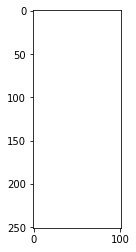

150
Ready: 066
Created.
Deleted.


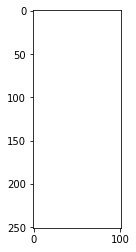

150
Ready: 067
Created.
Deleted.


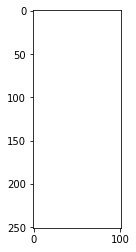

150
Ready: 068
Created.
Deleted.


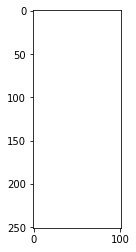

150
Ready: 069
Created.
Deleted.


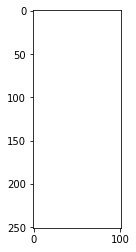

150
Ready: 070
Created.
Deleted.


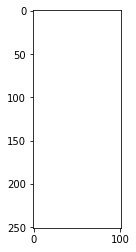

150
Ready: 071
Created.
Deleted.


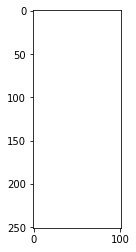

150
Ready: 072
Created.
Deleted.


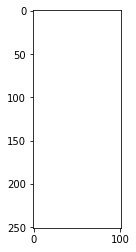

150
Ready: 073
Created.
Deleted.


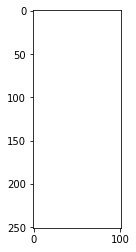

150
Ready: 074
Created.
Deleted.


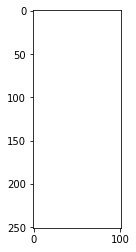

150
Ready: 075
Created.
Deleted.


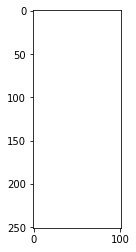

150
Ready: 076
Created.
Deleted.


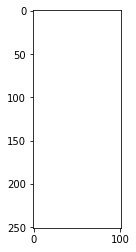

150
Ready: 077
Created.
Deleted.


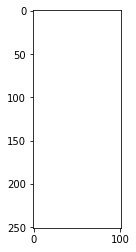

150
Ready: 078
Created.
Deleted.


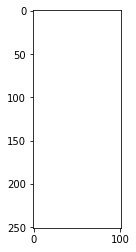

150
Ready: 079
Created.
Deleted.


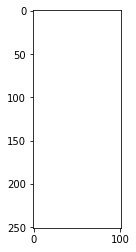

150
Ready: 080
Created.
Deleted.


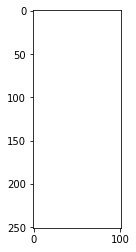

150
Ready: 081
Created.
Deleted.


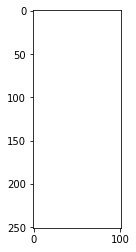

150
Ready: 082
Created.
Deleted.


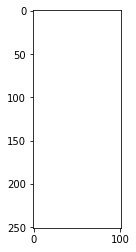

150
Ready: 083
Created.
Deleted.


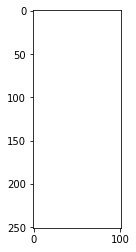

150
Ready: 084
Created.
Deleted.


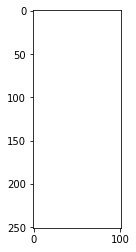

150
Ready: 085
Created.
Deleted.


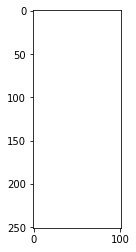

150
Ready: 086
Created.
Deleted.


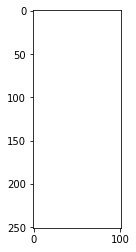

150
Ready: 087
Created.
Deleted.


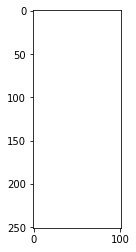

150
Ready: 088
Created.
Deleted.


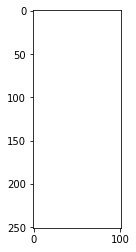

150
Ready: 089
Created.
Deleted.


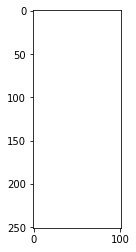

150
Ready: 090
Created.
Deleted.


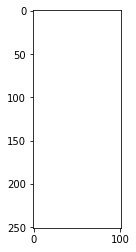

150
Ready: 091
Created.
Deleted.


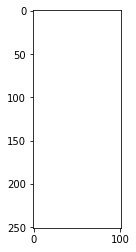

150
Ready: 092
Created.
Deleted.


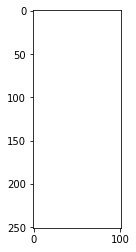

150
Ready: 093
Created.
Deleted.


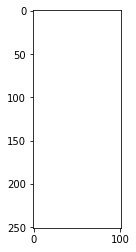

150
Ready: 094
Created.
Deleted.


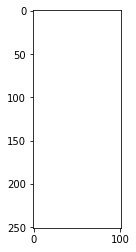

150
Ready: 095
Created.
Deleted.


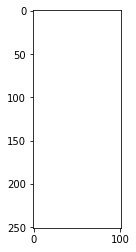

150
Ready: 096
Created.
Deleted.


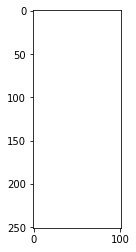

150
Ready: 097
Created.
Deleted.


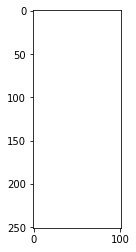

150
Ready: 098
Created.
Deleted.


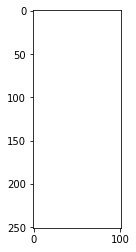

150
Ready: 099


In [199]:
blendy = Blend2()
for i in range(100):
    nest = StartingNest(startingPositionMatrix_=np.matrix([[0,0,0,0,0,0,0,0,0,2000,0,0,0,0,0,0,0,0,0]]), nodeArea_=7, iterations=67, areaX_=251, areaY_=101, T0=.6, Td=150)
    nest.run(.5)
    #nest.saveForGif(filename="kolmogorov_logo_1804_"+str("%03d" % i)+".png", img=nest.area)
    img = nest.area[:(nest.area.shape[0]//2)+1,:]
    scaling = 5
    img=np.kron(img, np.ones((scaling, scaling)))
    blendy.blend(inputMatrix=img, backgroundFileName="logo_background.png", outputFileName="exported_logo_"+str("%03d" % i)+".png")
    print("Ready:", str("%03d" % i))

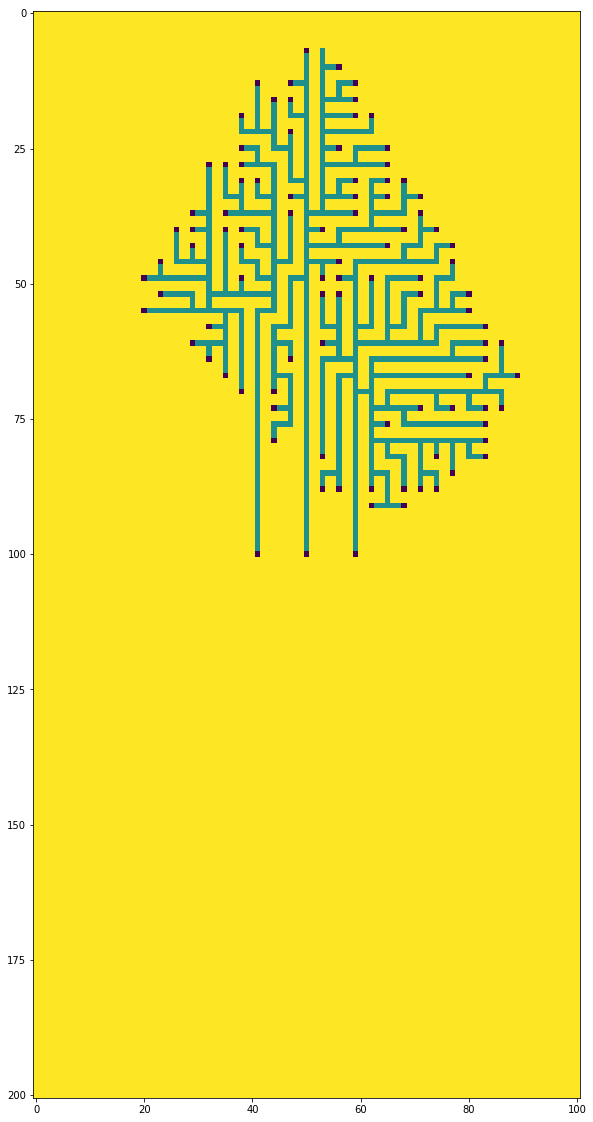

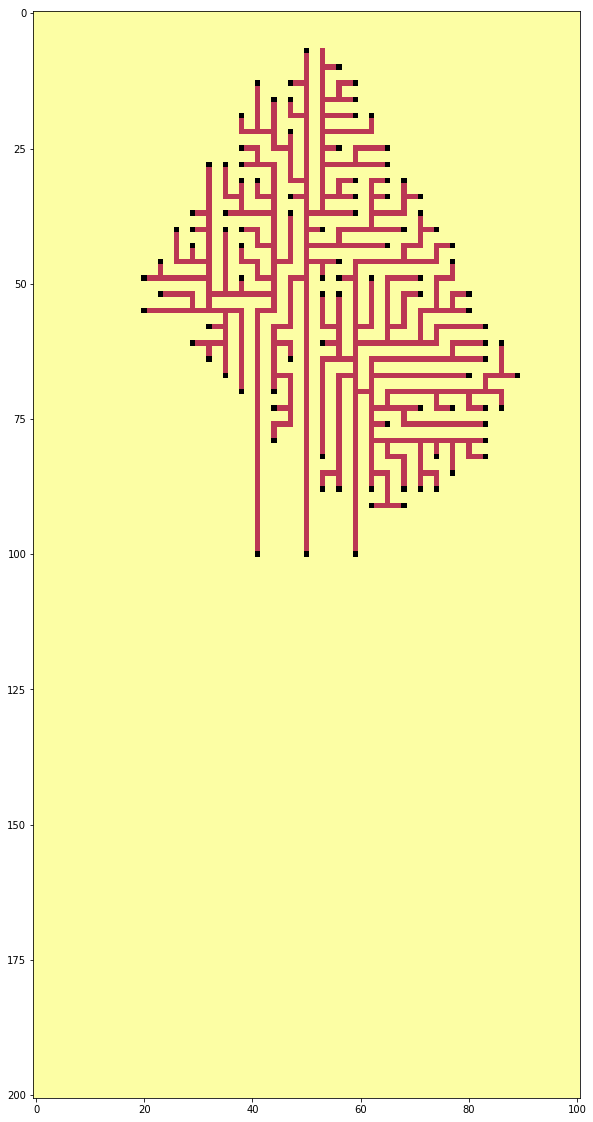

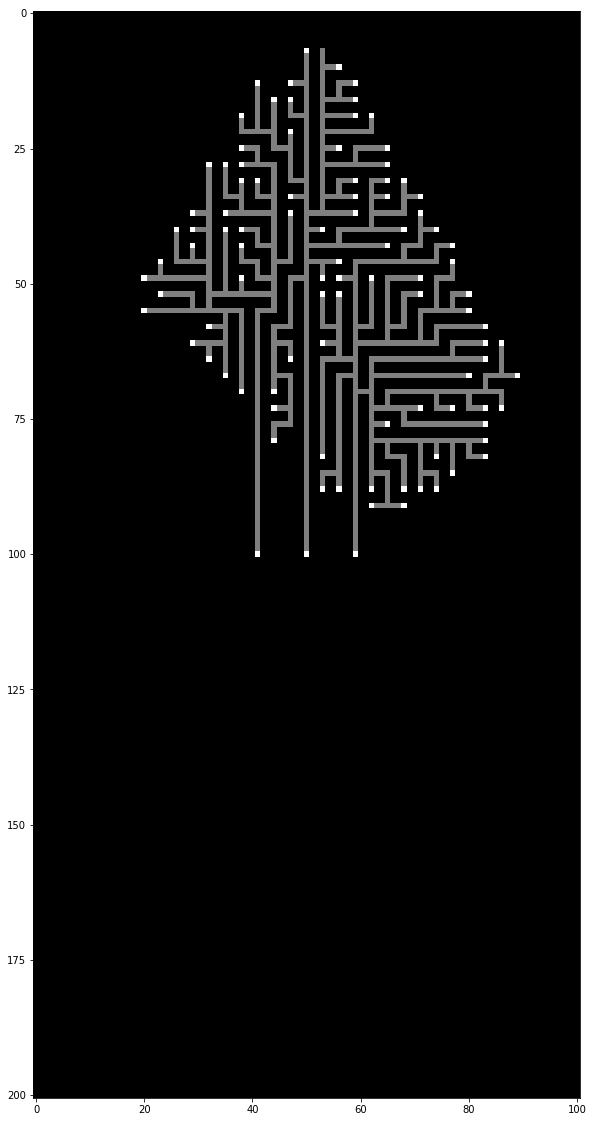

In [153]:
plt.figure(figsize = (20,20))
plt.imshow(1-testNest.area, cmap=plt.cm.viridis, interpolation='nearest', aspect='equal')
plt.show()
plt.figure(figsize = (20,20))
plt.imshow(1-testNest.area, cmap=plt.cm.inferno, interpolation='nearest', aspect='equal')
plt.show()
plt.figure(figsize = (20,20))
plt.imshow(1-testNest.area, cmap=plt.cm.binary, interpolation='nearest', aspect='equal')
plt.show()

In [121]:
#blend(self, inputMatrix, backgroundFileName, outputFileName)
blendy = Blend2()
blendy.blend(inputMatrix=testNest.area, backgroundFileName="logo_background.png", outputFileName="test_logo.png")